In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
class OverFeatAccurate(nn.Module):
    def __init__(self, num_classes=100):
        super(OverFeatAccurate, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(1024 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x


class OverFeatFast(nn.Module):
    def __init__(self, num_classes=100):
        super(OverFeatFast, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(512 * 7 * 7, 3072)
        self.fc2 = nn.Linear(3072, 3072)
        self.fc3 = nn.Linear(3072, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [4]:
trainset = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False, num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
accurate_model = OverFeatAccurate(num_classes=100).to(device)
fast_model = OverFeatFast(num_classes=100).to(device)

In [7]:
print("Accurate Model Summary:")
summary(accurate_model, input_size=(3, 224, 224), device=str(device))

Accurate Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
            Conv2d-2          [-1, 256, 28, 28]         614,656
            Conv2d-3          [-1, 512, 14, 14]       1,180,160
            Conv2d-4         [-1, 1024, 14, 14]       4,719,616
            Conv2d-5         [-1, 1024, 14, 14]       9,438,208
            Linear-6                 [-1, 4096]     205,524,992
            Linear-7                 [-1, 4096]      16,781,312
            Linear-8                  [-1, 100]         409,700
Total params: 238,703,588
Trainable params: 238,703,588
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 7.64
Params size (MB): 910.58
Estimated Total Size (MB): 918.79
----------------------------------------------------------------


In [8]:
print("\nFast Model Summary:")
summary(fast_model, input_size=(3, 224, 224), device=str(device))


Fast Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
            Conv2d-2          [-1, 192, 28, 28]         307,392
            Conv2d-3          [-1, 384, 14, 14]         663,936
            Conv2d-4          [-1, 512, 14, 14]       1,769,984
            Conv2d-5          [-1, 512, 14, 14]       2,359,808
            Linear-6                 [-1, 3072]      77,073,408
            Linear-7                 [-1, 3072]       9,440,256
            Linear-8                  [-1, 100]         307,300
Total params: 91,945,380
Trainable params: 91,945,380
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.78
Params size (MB): 350.74
Estimated Total Size (MB): 356.10
----------------------------------------------------------------


In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
def train(model, optimizer, num_epochs=10):
    model.to(device)
    loss_values = []
    accuracy_values = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        model.train()
        progress_bar = tqdm(
            enumerate(trainloader, 0),
            total=len(trainloader),
            desc=f"Epoch {epoch+1}/{num_epochs}",
        )
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(
                loss=running_loss / (i + 1), accuracy=100 * correct / total
            )

        loss_values.append(running_loss / len(trainloader))
        accuracy_values.append(100 * correct / total)
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}, Accuracy: {100 * correct / total:.2f}%"
        )

    return loss_values, accuracy_values

In [11]:
epochs = 100

optimizer_accurate = optim.SGD(accurate_model.parameters(), lr=0.01, momentum=0.9)
optimizer_fast = optim.SGD(fast_model.parameters(), lr=0.01, momentum=0.9)

accurate_loss, accurate_acc = train(accurate_model, optimizer_accurate, num_epochs=epochs)
fast_loss, fast_acc = train(fast_model, optimizer_fast, num_epochs=epochs)

Epoch 1/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=2.62, loss=4.44] 

Epoch [1/100], Loss: 4.4435, Accuracy: 2.62%


Epoch 1/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=2.62, loss=4.44]


Epoch [2/100], Loss: 3.8188, Accuracy: 10.34%


Epoch 3/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=19.9, loss=3.28]

Epoch [3/100], Loss: 3.2816, Accuracy: 19.94%


Epoch 3/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=19.9, loss=3.28]


Epoch [4/100], Loss: 2.8154, Accuracy: 29.25%


Epoch 5/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=38, loss=2.4]   

Epoch [5/100], Loss: 2.3991, Accuracy: 37.99%


Epoch 5/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=38, loss=2.4]


Epoch [6/100], Loss: 2.0212, Accuracy: 45.86%


Epoch 7/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=54.6, loss=1.66]

Epoch [7/100], Loss: 1.6559, Accuracy: 54.59%


Epoch 7/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=54.6, loss=1.66]


Epoch [8/100], Loss: 1.2941, Accuracy: 63.37%


Epoch 9/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=71.9, loss=0.966]

Epoch [9/100], Loss: 0.9664, Accuracy: 71.87%


Epoch 9/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=71.9, loss=0.966]


Epoch [10/100], Loss: 0.7212, Accuracy: 78.64%


Epoch 11/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=83.4, loss=0.552]

Epoch [11/100], Loss: 0.5519, Accuracy: 83.37%


Epoch 11/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=83.4, loss=0.552]


Epoch [12/100], Loss: 0.4543, Accuracy: 86.49%


Epoch 13/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=88.6, loss=0.376]

Epoch [13/100], Loss: 0.3761, Accuracy: 88.64%


Epoch 13/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=88.6, loss=0.376]


Epoch [14/100], Loss: 0.3363, Accuracy: 90.10%


Epoch 15/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=92, loss=0.274]  

Epoch [15/100], Loss: 0.2740, Accuracy: 91.98%


Epoch 15/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=92, loss=0.274]


Epoch [16/100], Loss: 0.2379, Accuracy: 93.08%


Epoch 17/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=93.9, loss=0.208] 

Epoch [17/100], Loss: 0.2082, Accuracy: 93.93%


Epoch 17/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=93.9, loss=0.208]


Epoch [18/100], Loss: 0.2006, Accuracy: 94.22%


Epoch 19/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=95, loss=0.177]  

Epoch [19/100], Loss: 0.1766, Accuracy: 94.99%


Epoch 19/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=95, loss=0.177]


Epoch [20/100], Loss: 0.1828, Accuracy: 94.74%


Epoch 21/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=95.7, loss=0.15] 

Epoch [21/100], Loss: 0.1497, Accuracy: 95.65%


Epoch 21/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=95.7, loss=0.15]


Epoch [22/100], Loss: 0.1563, Accuracy: 95.52%


Epoch 23/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=95.9, loss=0.147]

Epoch [23/100], Loss: 0.1466, Accuracy: 95.90%


Epoch 23/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=95.9, loss=0.147]


Epoch [24/100], Loss: 0.1352, Accuracy: 96.13%


Epoch 25/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=96.3, loss=0.132] 

Epoch [25/100], Loss: 0.1321, Accuracy: 96.28%


Epoch 25/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=96.3, loss=0.132]


Epoch [26/100], Loss: 0.1231, Accuracy: 96.63%


Epoch 27/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=96.7, loss=0.12]  

Epoch [27/100], Loss: 0.1198, Accuracy: 96.65%


Epoch 27/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=96.7, loss=0.12]


Epoch [28/100], Loss: 0.1087, Accuracy: 96.94%


Epoch 29/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.1, loss=0.107] 

Epoch [29/100], Loss: 0.1075, Accuracy: 97.14%


Epoch 29/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.1, loss=0.107]


Epoch [30/100], Loss: 0.1083, Accuracy: 96.97%


Epoch 31/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.1, loss=0.106] 

Epoch [31/100], Loss: 0.1061, Accuracy: 97.06%


Epoch 31/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.1, loss=0.106]


Epoch [32/100], Loss: 0.1027, Accuracy: 97.09%


Epoch 33/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97, loss=0.109]   

Epoch [33/100], Loss: 0.1087, Accuracy: 97.04%


Epoch 33/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97, loss=0.109]


Epoch [34/100], Loss: 0.0942, Accuracy: 97.37%


Epoch 35/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.5, loss=0.0906]

Epoch [35/100], Loss: 0.0906, Accuracy: 97.47%


Epoch 35/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.5, loss=0.0906]


Epoch [36/100], Loss: 0.0949, Accuracy: 97.43%


Epoch 37/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.3, loss=0.0954]

Epoch [37/100], Loss: 0.0954, Accuracy: 97.32%


Epoch 37/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.3, loss=0.0954]


Epoch [38/100], Loss: 0.0972, Accuracy: 97.34%


Epoch 39/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.1, loss=0.105] 

Epoch [39/100], Loss: 0.1052, Accuracy: 97.13%


Epoch 39/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.1, loss=0.105]


Epoch [40/100], Loss: 0.0991, Accuracy: 97.31%


Epoch 41/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.7, loss=0.0894]

Epoch [41/100], Loss: 0.0894, Accuracy: 97.68%


Epoch 41/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.7, loss=0.0894]


Epoch [42/100], Loss: 0.1007, Accuracy: 97.34%


Epoch 43/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.3, loss=0.0994]

Epoch [43/100], Loss: 0.0994, Accuracy: 97.28%


Epoch 43/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.3, loss=0.0994]


Epoch [44/100], Loss: 0.1002, Accuracy: 97.36%


Epoch 45/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.5, loss=0.0926]

Epoch [45/100], Loss: 0.0926, Accuracy: 97.53%


Epoch 45/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.5, loss=0.0926]


Epoch [46/100], Loss: 0.0933, Accuracy: 97.53%


Epoch 47/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.5, loss=0.0959]

Epoch [47/100], Loss: 0.0959, Accuracy: 97.48%


Epoch 47/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.5, loss=0.0959]


Epoch [48/100], Loss: 0.0878, Accuracy: 97.66%


Epoch 49/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.5, loss=0.0947]

Epoch [49/100], Loss: 0.0947, Accuracy: 97.50%


Epoch 49/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.5, loss=0.0947]


Epoch [50/100], Loss: 0.0930, Accuracy: 97.62%


Epoch 51/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.8, loss=0.0811]

Epoch [51/100], Loss: 0.0811, Accuracy: 97.85%


Epoch 51/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.8, loss=0.0811]


Epoch [52/100], Loss: 0.0954, Accuracy: 97.51%


Epoch 53/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.5, loss=0.096] 

Epoch [53/100], Loss: 0.0960, Accuracy: 97.54%


Epoch 53/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.5, loss=0.096]


Epoch [54/100], Loss: 0.0931, Accuracy: 97.69%


Epoch 55/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.5, loss=0.0985]

Epoch [55/100], Loss: 0.0985, Accuracy: 97.47%


Epoch 55/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.5, loss=0.0985]


Epoch [56/100], Loss: 0.1026, Accuracy: 97.35%


Epoch 57/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.5, loss=0.0938]

Epoch [57/100], Loss: 0.0938, Accuracy: 97.54%


Epoch 57/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.5, loss=0.0938]


Epoch [58/100], Loss: 0.0896, Accuracy: 97.69%


Epoch 59/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.8, loss=0.0825]

Epoch [59/100], Loss: 0.0825, Accuracy: 97.83%


Epoch 59/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.8, loss=0.0825]


Epoch [60/100], Loss: 0.0870, Accuracy: 97.75%


Epoch 61/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97.3, loss=0.115] 

Epoch [61/100], Loss: 0.1155, Accuracy: 97.30%


Epoch 61/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97.3, loss=0.115]


Epoch [62/100], Loss: 0.1047, Accuracy: 97.36%


Epoch 63/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97, loss=0.116]   

Epoch [63/100], Loss: 0.1161, Accuracy: 97.04%


Epoch 63/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97, loss=0.116]


Epoch [64/100], Loss: 0.1302, Accuracy: 96.85%


Epoch 65/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=97, loss=0.119]  

Epoch [65/100], Loss: 0.1192, Accuracy: 96.97%


Epoch 65/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=97, loss=0.119]


Epoch [66/100], Loss: 0.1278, Accuracy: 96.90%


Epoch 67/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=96.9, loss=0.129] 

Epoch [67/100], Loss: 0.1290, Accuracy: 96.93%


Epoch 67/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=96.9, loss=0.129]


Epoch [68/100], Loss: 0.1489, Accuracy: 96.37%


Epoch 69/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=96.5, loss=0.143] 

Epoch [69/100], Loss: 0.1428, Accuracy: 96.50%


Epoch 69/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=96.5, loss=0.143]


Epoch [70/100], Loss: 0.1825, Accuracy: 95.74%


Epoch 71/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=95.9, loss=0.174]

Epoch [71/100], Loss: 0.1743, Accuracy: 95.88%


Epoch 71/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=95.9, loss=0.174]


Epoch [72/100], Loss: 0.1592, Accuracy: 96.19%


Epoch 73/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=96, loss=0.172]  

Epoch [73/100], Loss: 0.1721, Accuracy: 96.01%


Epoch 73/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=96, loss=0.172]


Epoch [74/100], Loss: 0.1872, Accuracy: 95.66%


Epoch 75/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=95.4, loss=0.201] 

Epoch [75/100], Loss: 0.2011, Accuracy: 95.35%


Epoch 75/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=95.4, loss=0.201]


Epoch [76/100], Loss: 0.2174, Accuracy: 94.92%


Epoch 77/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=94.8, loss=0.231]

Epoch [77/100], Loss: 0.2306, Accuracy: 94.79%


Epoch 77/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=94.8, loss=0.231]


Epoch [78/100], Loss: 0.2135, Accuracy: 95.13%


Epoch 79/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=94.3, loss=0.258]

Epoch [79/100], Loss: 0.2580, Accuracy: 94.27%


Epoch 79/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=94.3, loss=0.258]


Epoch [80/100], Loss: 0.2816, Accuracy: 93.72%


Epoch 81/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=93.5, loss=0.295]

Epoch [81/100], Loss: 0.2949, Accuracy: 93.47%


Epoch 81/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=93.5, loss=0.295]


Epoch [82/100], Loss: 0.3156, Accuracy: 93.00%


Epoch 83/100:   0%|          | 0/782 [01:16<?, ?it/s, accuracy=92.5, loss=0.348]

Epoch [83/100], Loss: 0.3476, Accuracy: 92.47%


Epoch 83/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=92.5, loss=0.348]


Epoch [84/100], Loss: 0.3885, Accuracy: 91.65%


Epoch 85/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=90.8, loss=0.437]

Epoch [85/100], Loss: 0.4370, Accuracy: 90.76%


Epoch 85/100:   0%|          | 0/782 [01:21<?, ?it/s, accuracy=90.8, loss=0.437]


Epoch [86/100], Loss: 0.4575, Accuracy: 90.16%


Epoch 87/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=88.9, loss=0.528]

Epoch [87/100], Loss: 0.5279, Accuracy: 88.93%


Epoch 87/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=88.9, loss=0.528]


Epoch [88/100], Loss: 0.6058, Accuracy: 87.38%


Epoch 89/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=86.1, loss=0.678]

Epoch [89/100], Loss: 0.6777, Accuracy: 86.14%


Epoch 89/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=86.1, loss=0.678]


Epoch [90/100], Loss: 0.7630, Accuracy: 84.38%


Epoch 91/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=83.5, loss=0.802]

Epoch [91/100], Loss: 0.8017, Accuracy: 83.46%


Epoch 91/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=83.5, loss=0.802]


Epoch [92/100], Loss: 0.9657, Accuracy: 80.47%


Epoch 93/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=77.5, loss=1.12] 

Epoch [93/100], Loss: 1.1239, Accuracy: 77.53%


Epoch 93/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=77.5, loss=1.12]


Epoch [94/100], Loss: 1.2459, Accuracy: 74.86%


Epoch 95/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=70, loss=1.51]  

Epoch [95/100], Loss: 1.5101, Accuracy: 69.98%


Epoch 95/100:   0%|          | 0/782 [01:22<?, ?it/s, accuracy=70, loss=1.51]


Epoch [96/100], Loss: 1.6687, Accuracy: 66.42%


Epoch 97/100:   0%|          | 0/782 [01:18<?, ?it/s, accuracy=64.1, loss=1.8] 

Epoch [97/100], Loss: 1.7969, Accuracy: 64.08%


Epoch 97/100:   0%|          | 0/782 [01:23<?, ?it/s, accuracy=64.1, loss=1.8]


Epoch [98/100], Loss: 1.9829, Accuracy: 60.46%


Epoch 99/100:   0%|          | 0/782 [01:17<?, ?it/s, accuracy=58.5, loss=2.06]

Epoch [99/100], Loss: 2.0613, Accuracy: 58.54%


Epoch 100/100:   0%|          | 0/782 [01:18<?, ?it/s, accuracy=52.5, loss=2.37]

Epoch [100/100], Loss: 2.3724, Accuracy: 52.46%



Epoch 1/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=2.51, loss=4.44] 

Epoch [1/100], Loss: 4.4445, Accuracy: 2.51%


Epoch 1/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=2.51, loss=4.44]


Epoch [2/100], Loss: 3.8948, Accuracy: 9.31%


Epoch 3/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=18.4, loss=3.36]

Epoch [3/100], Loss: 3.3611, Accuracy: 18.41%


Epoch 3/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=18.4, loss=3.36]


Epoch [4/100], Loss: 2.9311, Accuracy: 26.62%


Epoch 5/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=34.3, loss=2.55]

Epoch [5/100], Loss: 2.5501, Accuracy: 34.31%


Epoch 5/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=34.3, loss=2.55]


Epoch [6/100], Loss: 2.1984, Accuracy: 42.08%


Epoch 7/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=49.1, loss=1.88]

Epoch [7/100], Loss: 1.8809, Accuracy: 49.08%


Epoch 7/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=49.1, loss=1.88]


Epoch [8/100], Loss: 1.5760, Accuracy: 56.36%


Epoch 9/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=63.7, loss=1.29]

Epoch [9/100], Loss: 1.2869, Accuracy: 63.66%


Epoch 9/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=63.7, loss=1.29]


Epoch [10/100], Loss: 1.0511, Accuracy: 69.38%


Epoch 11/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=74.7, loss=0.856]

Epoch [11/100], Loss: 0.8558, Accuracy: 74.74%


Epoch 11/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=74.7, loss=0.856]


Epoch [12/100], Loss: 0.7094, Accuracy: 78.89%


Epoch 13/100:   0%|          | 0/782 [00:41<?, ?it/s, accuracy=82.1, loss=0.611]

Epoch [13/100], Loss: 0.6107, Accuracy: 82.05%


Epoch 13/100:   0%|          | 0/782 [00:46<?, ?it/s, accuracy=82.1, loss=0.611]


Epoch [14/100], Loss: 0.5496, Accuracy: 83.76%


Epoch 15/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=86, loss=0.47]   

Epoch [15/100], Loss: 0.4696, Accuracy: 85.98%


Epoch 15/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=86, loss=0.47]


Epoch [16/100], Loss: 0.4459, Accuracy: 86.97%


Epoch 17/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=88.9, loss=0.385]

Epoch [17/100], Loss: 0.3846, Accuracy: 88.91%


Epoch 17/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=88.9, loss=0.385]


Epoch [18/100], Loss: 0.3792, Accuracy: 88.97%


Epoch 19/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=89.9, loss=0.35] 

Epoch [19/100], Loss: 0.3503, Accuracy: 89.85%


Epoch 19/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=89.9, loss=0.35]


Epoch [20/100], Loss: 0.3140, Accuracy: 90.96%


Epoch 21/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=90.8, loss=0.323]

Epoch [21/100], Loss: 0.3226, Accuracy: 90.78%


Epoch 21/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=90.8, loss=0.323]


Epoch [22/100], Loss: 0.3028, Accuracy: 91.34%


Epoch 23/100:   0%|          | 0/782 [00:41<?, ?it/s, accuracy=91.5, loss=0.298]

Epoch [23/100], Loss: 0.2985, Accuracy: 91.54%


Epoch 23/100:   0%|          | 0/782 [00:46<?, ?it/s, accuracy=91.5, loss=0.298]


Epoch [24/100], Loss: 0.2805, Accuracy: 92.14%


Epoch 25/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=92.5, loss=0.27] 

Epoch [25/100], Loss: 0.2698, Accuracy: 92.50%


Epoch 25/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=92.5, loss=0.27]


Epoch [26/100], Loss: 0.2792, Accuracy: 92.31%


Epoch 27/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=92.1, loss=0.282]

Epoch [27/100], Loss: 0.2823, Accuracy: 92.08%


Epoch 27/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=92.1, loss=0.282]


Epoch [28/100], Loss: 0.2768, Accuracy: 92.45%


Epoch 29/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=92.7, loss=0.27] 

Epoch [29/100], Loss: 0.2699, Accuracy: 92.70%


Epoch 29/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=92.7, loss=0.27]


Epoch [30/100], Loss: 0.2841, Accuracy: 92.21%


Epoch 31/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=92.1, loss=0.287]

Epoch [31/100], Loss: 0.2875, Accuracy: 92.13%


Epoch 31/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=92.1, loss=0.287]


Epoch [32/100], Loss: 0.2835, Accuracy: 92.32%


Epoch 33/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=92.3, loss=0.293]

Epoch [33/100], Loss: 0.2934, Accuracy: 92.27%


Epoch 33/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=92.3, loss=0.293]


Epoch [34/100], Loss: 0.3026, Accuracy: 92.12%


Epoch 35/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=92.1, loss=0.303]

Epoch [35/100], Loss: 0.3031, Accuracy: 92.13%


Epoch 35/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=92.1, loss=0.303]


Epoch [36/100], Loss: 0.3200, Accuracy: 91.70%


Epoch 37/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=91.7, loss=0.317]

Epoch [37/100], Loss: 0.3167, Accuracy: 91.72%


Epoch 37/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=91.7, loss=0.317]


Epoch [38/100], Loss: 0.3440, Accuracy: 91.16%


Epoch 39/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=90.5, loss=0.373]

Epoch [39/100], Loss: 0.3730, Accuracy: 90.53%


Epoch 39/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=90.5, loss=0.373]


Epoch [40/100], Loss: 0.3786, Accuracy: 90.57%


Epoch 41/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=89.4, loss=0.42]  

Epoch [41/100], Loss: 0.4201, Accuracy: 89.37%


Epoch 41/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=89.4, loss=0.42]


Epoch [42/100], Loss: 0.4424, Accuracy: 89.01%


Epoch 43/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=88.1, loss=0.489]

Epoch [43/100], Loss: 0.4887, Accuracy: 88.11%


Epoch 43/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=88.1, loss=0.489]


Epoch [44/100], Loss: 0.5131, Accuracy: 87.43%


Epoch 45/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=87, loss=0.539]  

Epoch [45/100], Loss: 0.5389, Accuracy: 86.98%


Epoch 45/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=87, loss=0.539]


Epoch [46/100], Loss: 0.5880, Accuracy: 86.09%


Epoch 47/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=84.6, loss=0.647]

Epoch [47/100], Loss: 0.6468, Accuracy: 84.57%


Epoch 47/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=84.6, loss=0.647]


Epoch [48/100], Loss: 0.6986, Accuracy: 83.63%


Epoch 49/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=82.7, loss=0.751]

Epoch [49/100], Loss: 0.7509, Accuracy: 82.72%


Epoch 49/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=82.7, loss=0.751]


Epoch [50/100], Loss: 0.8284, Accuracy: 80.87%


Epoch 51/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=78.4, loss=0.948]

Epoch [51/100], Loss: 0.9476, Accuracy: 78.44%


Epoch 51/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=78.4, loss=0.948]


Epoch [52/100], Loss: 1.0289, Accuracy: 76.94%


Epoch 53/100:   0%|          | 0/782 [00:41<?, ?it/s, accuracy=74.7, loss=1.13] 

Epoch [53/100], Loss: 1.1342, Accuracy: 74.65%


Epoch 53/100:   0%|          | 0/782 [00:46<?, ?it/s, accuracy=74.7, loss=1.13]


Epoch [54/100], Loss: 1.1948, Accuracy: 73.39%


Epoch 55/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=69.3, loss=1.4]  

Epoch [55/100], Loss: 1.4023, Accuracy: 69.25%


Epoch 55/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=69.3, loss=1.4]


Epoch [56/100], Loss: 1.5002, Accuracy: 67.15%


Epoch 57/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=65, loss=1.6]   

Epoch [57/100], Loss: 1.6002, Accuracy: 65.03%


Epoch 57/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=65, loss=1.6]


Epoch [58/100], Loss: 1.7261, Accuracy: 62.53%


Epoch 59/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=61.7, loss=1.77]

Epoch [59/100], Loss: 1.7698, Accuracy: 61.68%


Epoch 59/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=61.7, loss=1.77]


Epoch [60/100], Loss: 1.9700, Accuracy: 57.81%


Epoch 61/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=57.2, loss=1.99]

Epoch [61/100], Loss: 1.9903, Accuracy: 57.21%


Epoch 61/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=57.2, loss=1.99]


Epoch [62/100], Loss: 2.1457, Accuracy: 54.14%


Epoch 63/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=50.1, loss=2.34]

Epoch [63/100], Loss: 2.3444, Accuracy: 50.07%


Epoch 63/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=50.1, loss=2.34]


Epoch [64/100], Loss: 2.3864, Accuracy: 49.15%


Epoch 65/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=47.3, loss=2.46]

Epoch [65/100], Loss: 2.4608, Accuracy: 47.33%


Epoch 65/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=47.3, loss=2.46]


Epoch [66/100], Loss: 2.5772, Accuracy: 45.15%


Epoch 67/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=43.5, loss=2.65]

Epoch [67/100], Loss: 2.6474, Accuracy: 43.50%


Epoch 67/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=43.5, loss=2.65]


Epoch [68/100], Loss: 2.7617, Accuracy: 41.38%


Epoch 69/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=42.2, loss=2.7] 

Epoch [69/100], Loss: 2.7003, Accuracy: 42.17%


Epoch 69/100:   0%|          | 0/782 [00:46<?, ?it/s, accuracy=42.2, loss=2.7]


Epoch [70/100], Loss: 2.7657, Accuracy: 40.94%


Epoch 71/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=39.9, loss=2.83]

Epoch [71/100], Loss: 2.8272, Accuracy: 39.88%


Epoch 71/100:   0%|          | 0/782 [00:46<?, ?it/s, accuracy=39.9, loss=2.83]


Epoch [72/100], Loss: 2.8911, Accuracy: 38.51%


Epoch 73/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=37.3, loss=2.92]

Epoch [73/100], Loss: 2.9167, Accuracy: 37.35%


Epoch 73/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=37.3, loss=2.92]


Epoch [74/100], Loss: 2.9200, Accuracy: 37.75%


Epoch 75/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=36.4, loss=2.99]

Epoch [75/100], Loss: 2.9907, Accuracy: 36.43%


Epoch 75/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=36.4, loss=2.99]


Epoch [76/100], Loss: 2.9869, Accuracy: 36.27%


Epoch 77/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=31.9, loss=3.21]

Epoch [77/100], Loss: 3.2073, Accuracy: 31.89%


Epoch 77/100:   0%|          | 0/782 [00:46<?, ?it/s, accuracy=31.9, loss=3.21]


Epoch [78/100], Loss: 3.1606, Accuracy: 32.73%


Epoch 79/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=32.2, loss=3.19]

Epoch [79/100], Loss: 3.1913, Accuracy: 32.24%


Epoch 79/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=32.2, loss=3.19]


Epoch [80/100], Loss: 3.2772, Accuracy: 30.23%


Epoch 81/100:   0%|          | 0/782 [00:41<?, ?it/s, accuracy=28.5, loss=3.34]

Epoch [81/100], Loss: 3.3386, Accuracy: 28.45%


Epoch 81/100:   0%|          | 0/782 [00:46<?, ?it/s, accuracy=28.5, loss=3.34]


Epoch [82/100], Loss: 3.3439, Accuracy: 28.74%


Epoch 83/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=28.4, loss=3.36]

Epoch [83/100], Loss: 3.3561, Accuracy: 28.41%


Epoch 83/100:   0%|          | 0/782 [00:49<?, ?it/s, accuracy=28.4, loss=3.36]


Epoch [84/100], Loss: 3.2852, Accuracy: 29.86%


Epoch 85/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=26.6, loss=3.45]

Epoch [85/100], Loss: 3.4469, Accuracy: 26.57%


Epoch 85/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=26.6, loss=3.45]


Epoch [86/100], Loss: 3.3274, Accuracy: 28.57%


Epoch 87/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=27, loss=3.4]   

Epoch [87/100], Loss: 3.4027, Accuracy: 26.96%


Epoch 87/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=27, loss=3.4]


Epoch [88/100], Loss: 3.3807, Accuracy: 27.36%


Epoch 89/100:   0%|          | 0/782 [00:43<?, ?it/s, accuracy=26, loss=3.45]  

Epoch [89/100], Loss: 3.4516, Accuracy: 25.97%


Epoch 89/100:   0%|          | 0/782 [00:48<?, ?it/s, accuracy=26, loss=3.45]


Epoch [90/100], Loss: 3.4774, Accuracy: 25.33%


Epoch 91/100:   0%|          | 0/782 [00:43<?, ?it/s, accuracy=26.4, loss=3.42]

Epoch [91/100], Loss: 3.4221, Accuracy: 26.41%


Epoch 91/100:   0%|          | 0/782 [00:48<?, ?it/s, accuracy=26.4, loss=3.42]


Epoch [92/100], Loss: 3.4883, Accuracy: 24.91%


Epoch 93/100:   0%|          | 0/782 [00:42<?, ?it/s, accuracy=25.4, loss=3.47]

Epoch [93/100], Loss: 3.4660, Accuracy: 25.44%


Epoch 93/100:   0%|          | 0/782 [00:47<?, ?it/s, accuracy=25.4, loss=3.47]


Epoch [94/100], Loss: 3.4345, Accuracy: 26.17%


Epoch 95/100:   0%|          | 0/782 [00:43<?, ?it/s, accuracy=25.5, loss=3.46]

Epoch [95/100], Loss: 3.4563, Accuracy: 25.54%


Epoch 95/100:   0%|          | 0/782 [00:48<?, ?it/s, accuracy=25.5, loss=3.46]


Epoch [96/100], Loss: 3.4549, Accuracy: 25.91%


Epoch 97/100:   0%|          | 0/782 [00:43<?, ?it/s, accuracy=22.2, loss=3.62]

Epoch [97/100], Loss: 3.6205, Accuracy: 22.20%


Epoch 97/100:   0%|          | 0/782 [00:48<?, ?it/s, accuracy=22.2, loss=3.62]


Epoch [98/100], Loss: 3.5279, Accuracy: 24.26%


Epoch 99/100:   0%|          | 0/782 [00:43<?, ?it/s, accuracy=25.1, loss=3.49]

Epoch [99/100], Loss: 3.4886, Accuracy: 25.06%


Epoch 100/100:   0%|          | 0/782 [00:43<?, ?it/s, accuracy=23.5, loss=3.57]

Epoch [100/100], Loss: 3.5738, Accuracy: 23.49%


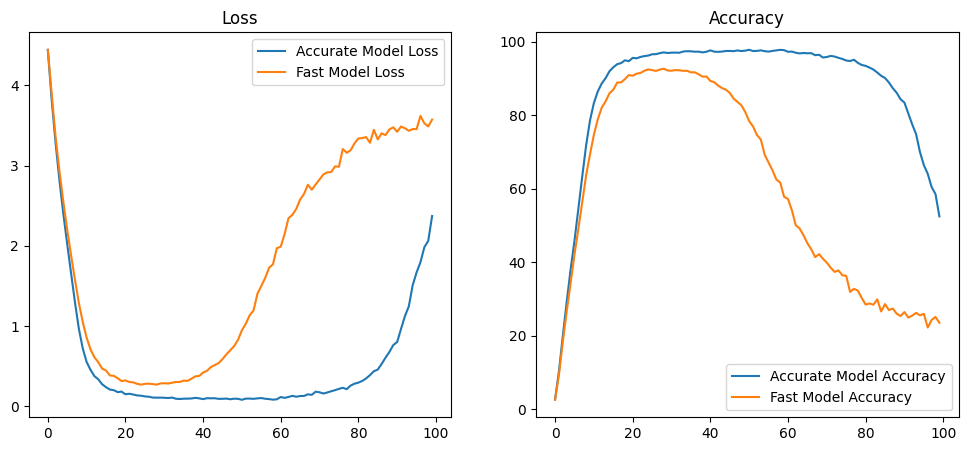

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(accurate_loss, label="Accurate Model Loss")
plt.plot(fast_loss, label="Fast Model Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accurate_acc, label="Accurate Model Accuracy")
plt.plot(fast_acc, label="Fast Model Accuracy")
plt.title("Accuracy")
plt.legend()

plt.show()